# Results Evaluation

In [1]:
%run ../scripts/load_df_for_analysis.py
%run ../scripts/data_visualisations.py
%run ../scripts/df_calculations.py
%run ../scripts/significance_tests.py

In [2]:
n_permutations = 1000

## Overall model results

### Comparison of best GPT and best Llama Model (from tested models on this data): <br>GPT 4.1 vs. Llama 3.1:70b

In [3]:
chunking = "1024_20"
only_text = True
model = "gpt-4.1-2025-04-14"
df_gpt = load_df_for_analysis(chunking, only_text, model)
results_gpt = eval_predictions(df_gpt, include_relabelled_partially=True)
results_gpt_no_partially = eval_predictions(df_gpt, include_relabelled_partially=False)

In [4]:
chunking = "256_20"
only_text = True
model = "llama3.1.70b"
df_llama = load_df_for_analysis(chunking, only_text, model)
results_llama = eval_predictions(df_llama, include_relabelled_partially=True)
results_llama_no_partially = eval_predictions(df_llama, include_relabelled_partially=False)

In [5]:
model_results = {
    "GPT-4.1 (1024 token chunks)": results_gpt,
    "Llama 3.1:70b (256 token chunks)": results_llama,
}

model_results_no_partially = {
    "GPT-4.1 (1024 token chunks)": results_gpt_no_partially,
    "Llama 3.1:70b (256 token chunks)": results_llama_no_partially
}

display_model_results_table(model_results)
display_model_results_table(model_results_no_partially)

,Balanced Accuracy,Precision (Unsubstantiated),Recall (Unsubstantiated),F1 Score (Unsubstantiated),Precision (Substantiated),Recall (Substantiated),F1 Score (Substantiated)
Model,,,,,,,
GPT-4.1 (1024 token chunks),0.856,0.877,0.809,0.842,0.844,0.902,0.872
Llama 3.1:70b (256 token chunks),0.810,0.748,0.878,0.808,0.875,0.742,0.803


,Balanced Accuracy,Precision (Unsubstantiated),Recall (Unsubstantiated),F1 Score (Unsubstantiated),Precision (Substantiated),Recall (Substantiated),F1 Score (Substantiated)
Model,,,,,,,
GPT-4.1 (1024 token chunks),0.873,0.890,0.832,0.860,0.865,0.913,0.888
Llama 3.1:70b (256 token chunks),0.836,0.756,0.925,0.832,0.922,0.746,0.825


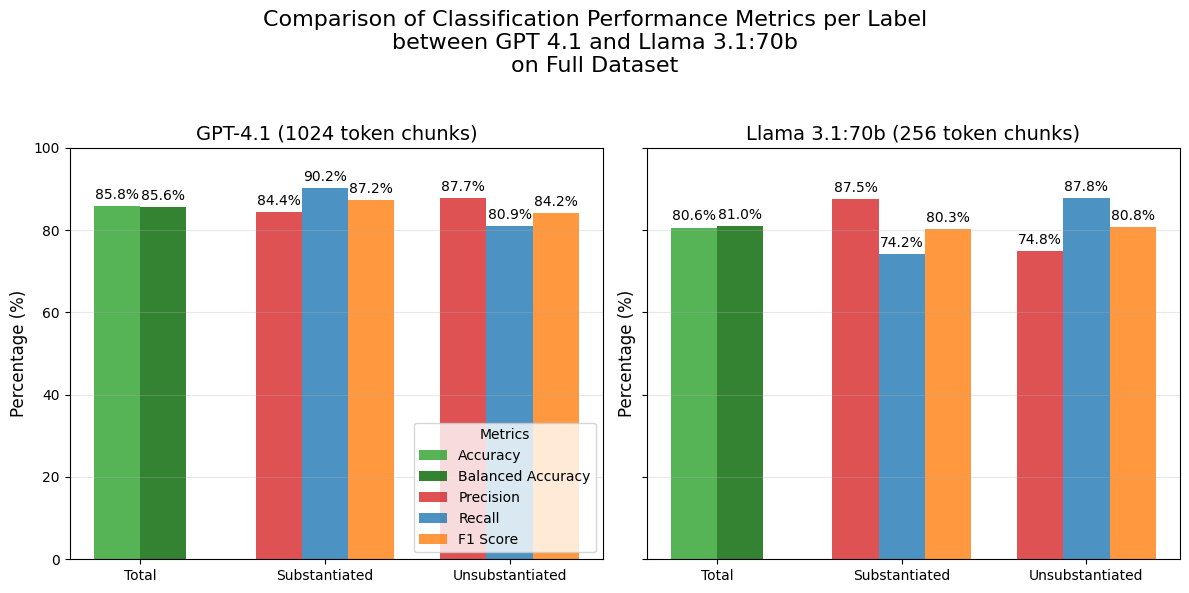

In [6]:
show_metrics_per_label(model_results, "Comparison of Classification Performance Metrics per Label\nbetween GPT 4.1 and Llama 3.1:70b\non Full Dataset")

## Comparison: Evaluation per Annotation Attribute

In [7]:
def attribute_predictions_per_model(model_dfs, attribute, relabelled_partially=False, group_numbers_from=False):
    results = {}
    for model_name, df in model_dfs.items():
        results[model_name] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=True, group_numbers_from=group_numbers_from)
        if relabelled_partially:
            results[model_name + " (exclude relabelled partially)"] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=False, group_numbers_from=group_numbers_from)
    return results

In [8]:
def fisher_exact_for_attribute(df, attribute, group_numbers_from=False):
    results = {}
    attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
    for group_name, attribute_values_list in attribute_groups:
        results[group_name] = calc_fisher_exact_total_sub_unsub(
            eval_attribute_subset_vs_rest(df, attribute, attribute_values_list)
        )
    display_fishers_exact_test_results(results)
    return results

In [9]:
def chi_squared_for_attribute(df, attribute, group_numbers_from=False):
    attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
    evals = eval_per_attribute_value(df, attribute, attribute_groups)
    results = calc_chi_squared_total_sub_unsub(evals, [group_name for group_name, _ in attribute_groups])
    display_chi_squared_test_results(results)
    return results

In [10]:
def permutation_test_for_attribute(df, attribute, group_numbers_from, n_permutations):
    results = calc_permutation_test_total_sub_unsub(df, attribute, group_numbers_from, n_permutations)
    display_permutation_test_results(results)
    return results

In [11]:
def significance_tests_for_attribute(df, model_name, attribute, group_numbers_from=False):
    global n_permutations
    
    results = {}
    print(f"---- ## Significance tests results for {model_name} on attribute '{attribute}': ## ----")
    # Fishers exact test
    print(f"Fisher's exact test results (per attribute value when compared to rest):")
    fisher_exact_results = fisher_exact_for_attribute(df, attribute, group_numbers_from)
    results['Fisher Exact'] = fisher_exact_results

    # Chi-Squared test
    print(f"Chi-squared test results (comparison over all attribute values):")
    chi_squared_results = chi_squared_for_attribute(df, attribute, group_numbers_from)
    results['Chi-Squared'] = chi_squared_results

    # Permutation test
    print(f"Permutation test results (comparison per metric over {n_permutations} permutations):")
    permutation_test_results = permutation_test_for_attribute(df, attribute, group_numbers_from, n_permutations)
    results['Permutation Test'] = permutation_test_results

    print("\n\n")
    return results

In [12]:
model_dfs = {  
    "GPT-4.1": df_gpt
}
analyzed_df = df_gpt
analyzed_model = "GPT-4.1"
significance_tests_results = {}

### Reference Only

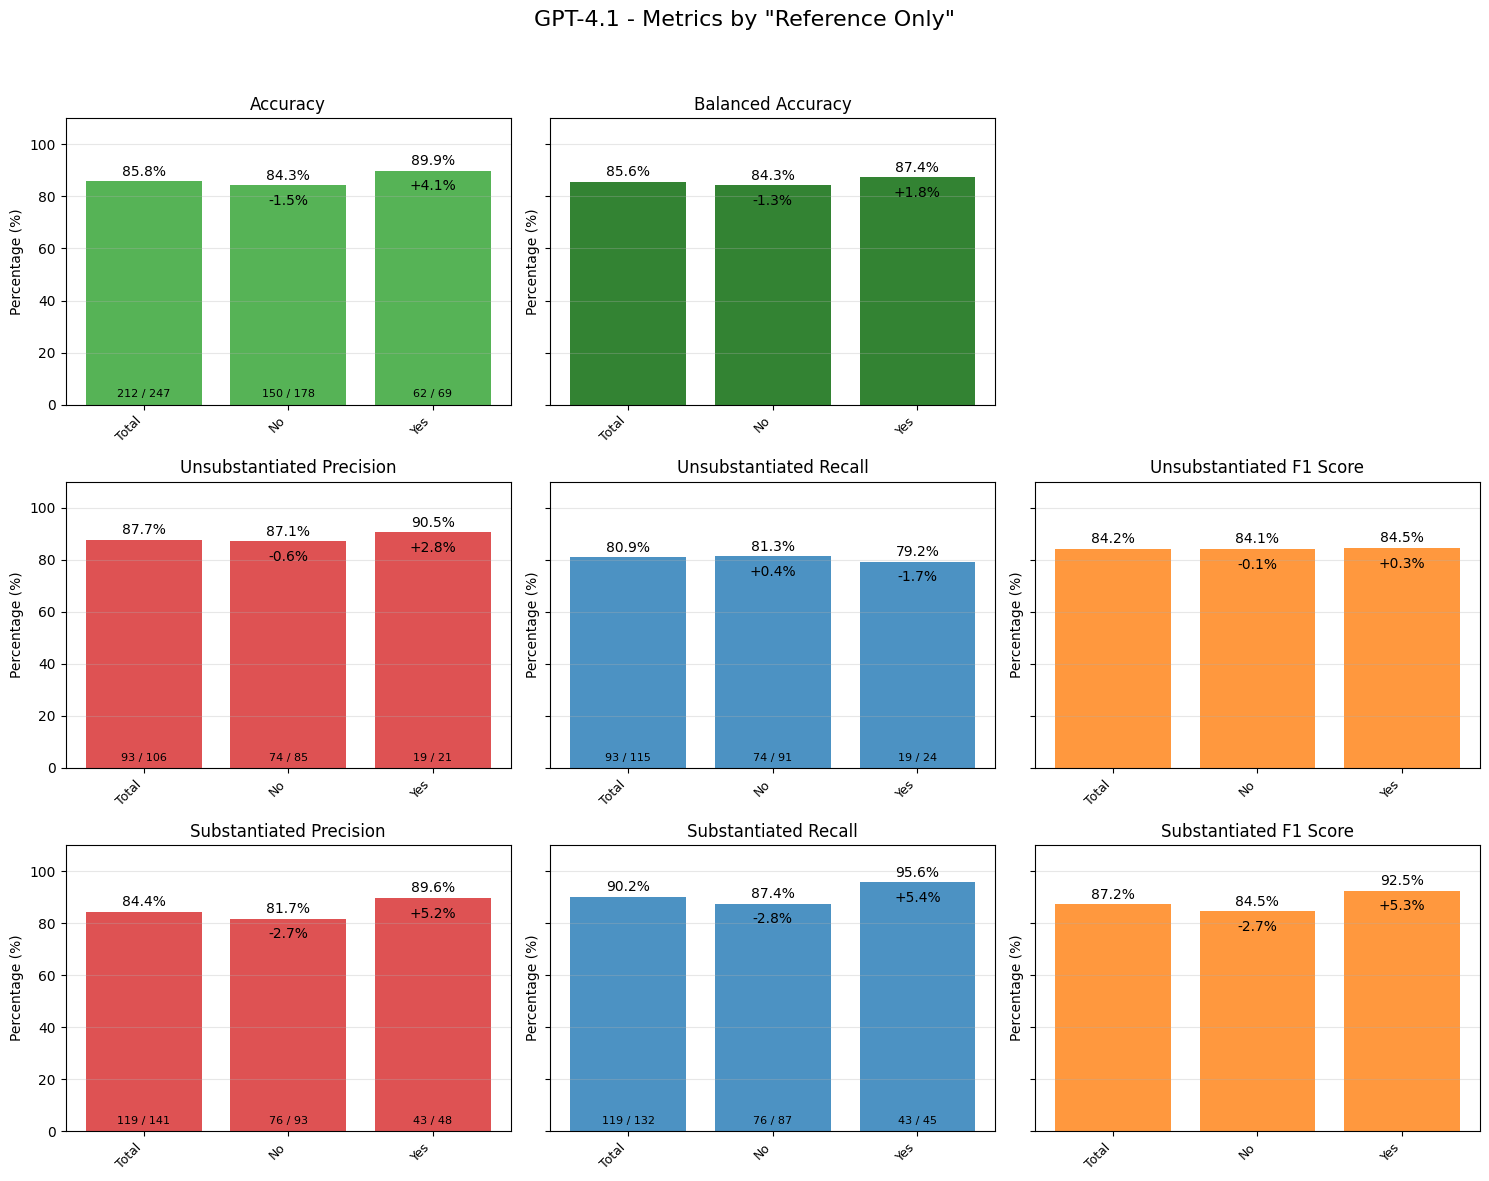

In [13]:
attribute = "Reference Only"
results = attribute_predictions_per_model(model_dfs, attribute)
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [14]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Reference Only': ## ----
Fisher's exact test results (per attribute value when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
Yes,1.6533,0.3129,0.8730,0.7769,3.1118,0.2172
No,0.6048,0.3129,1.1455,0.7769,0.3214,0.2172


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,1.3136,0.2517,0.0165,0.8978,0.6967,0.4039


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000000,0.3040,N/A,N/A,N/A,N/A
Accuracy,0.000500,0.1760,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.001100,0.7990,0.001500,0.1370
Recall,N/A,N/A,-0.001200,0.6430,0.000100,0.2720
F1 Score,N/A,N/A,-0.000600,0.6100,0.001100,0.0790


### Claim Contains Number or Formula

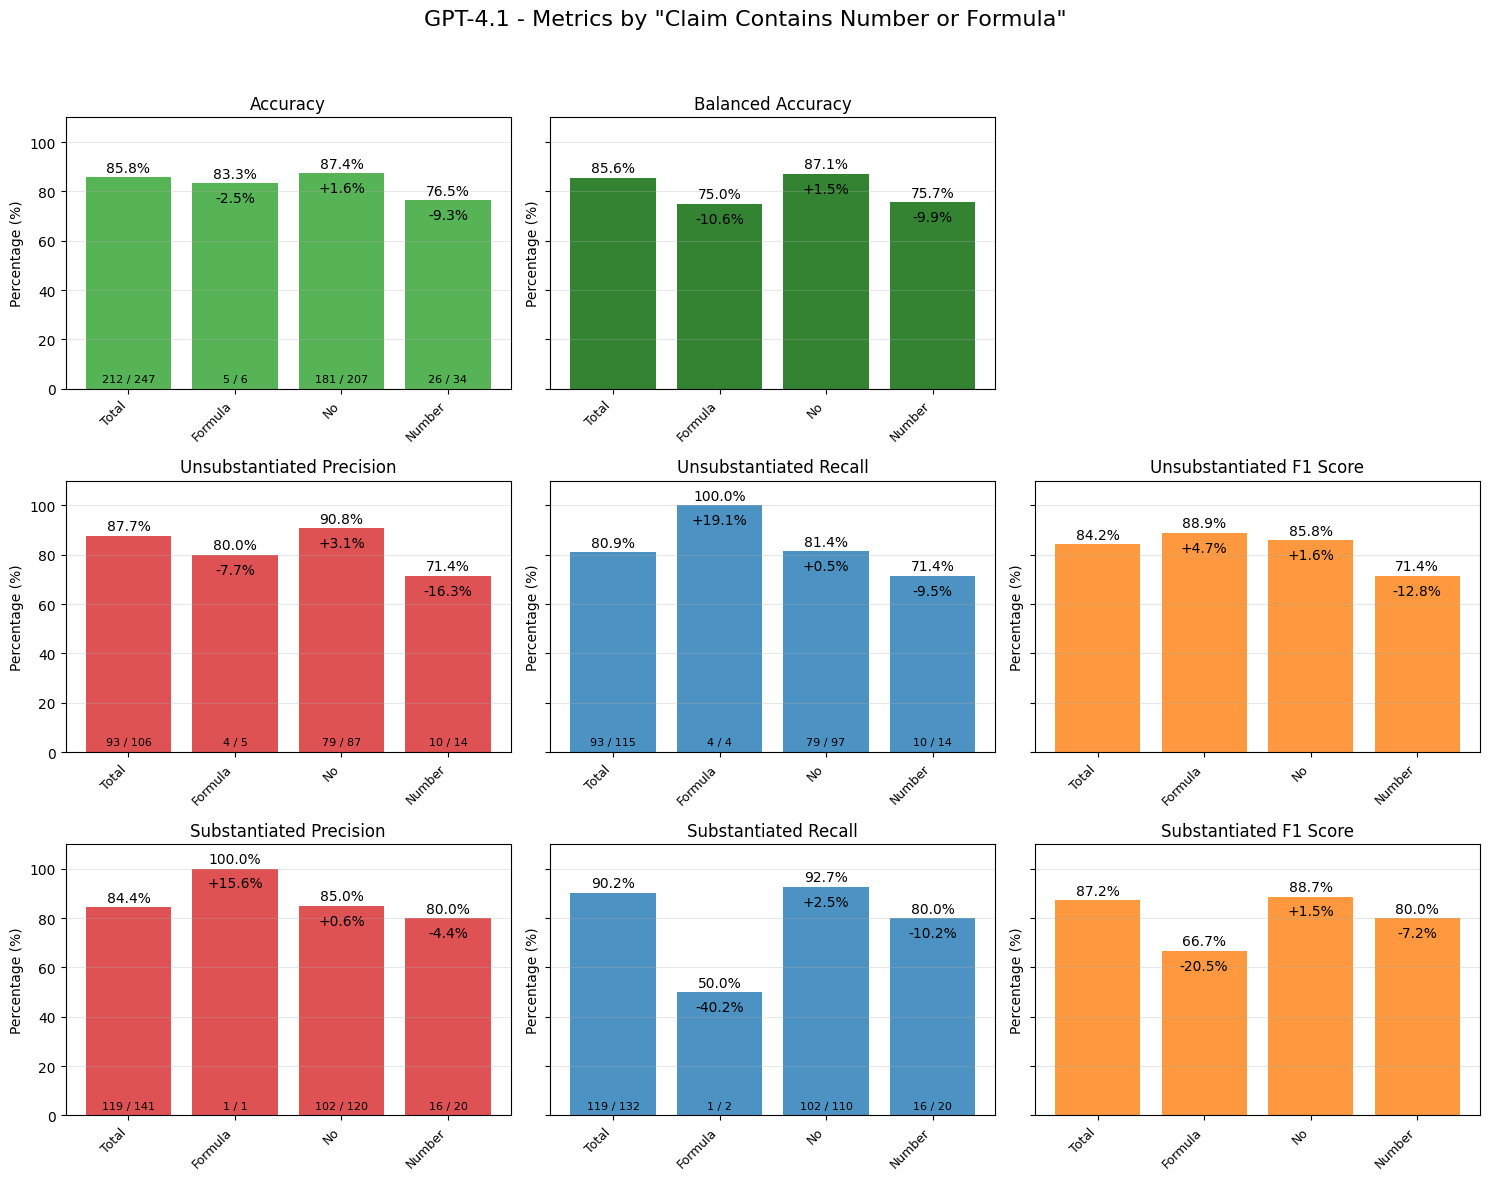

In [15]:
attribute = "Claim Contains Number or Formula"
results = attribute_predictions_per_model(model_dfs, attribute)
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [16]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model,attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Claim Contains Number or Formula': ## ----
Fisher's exact test results (per attribute value when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
No,2.0211,0.1337,1.2540,0.7467,3.7500,0.0421
Number,0.4718,0.1107,0.5422,0.4659,0.3495,0.1105
Formula,0.8213,1.0000,inf,1.0000,0.1017,0.1879


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,0.8352,0.6586,0.8448,0.6555,6.2995,0.0429


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.005300,0.7290,N/A,N/A,N/A,N/A
Accuracy,-0.004700,0.8810,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.016800,0.4140,-0.007700,0.7950
Recall,N/A,N/A,-0.015900,0.5610,0.025300,0.0580
F1 Score,N/A,N/A,-0.017000,0.7920,0.002200,0.1360


### Amount Citations in Sentence

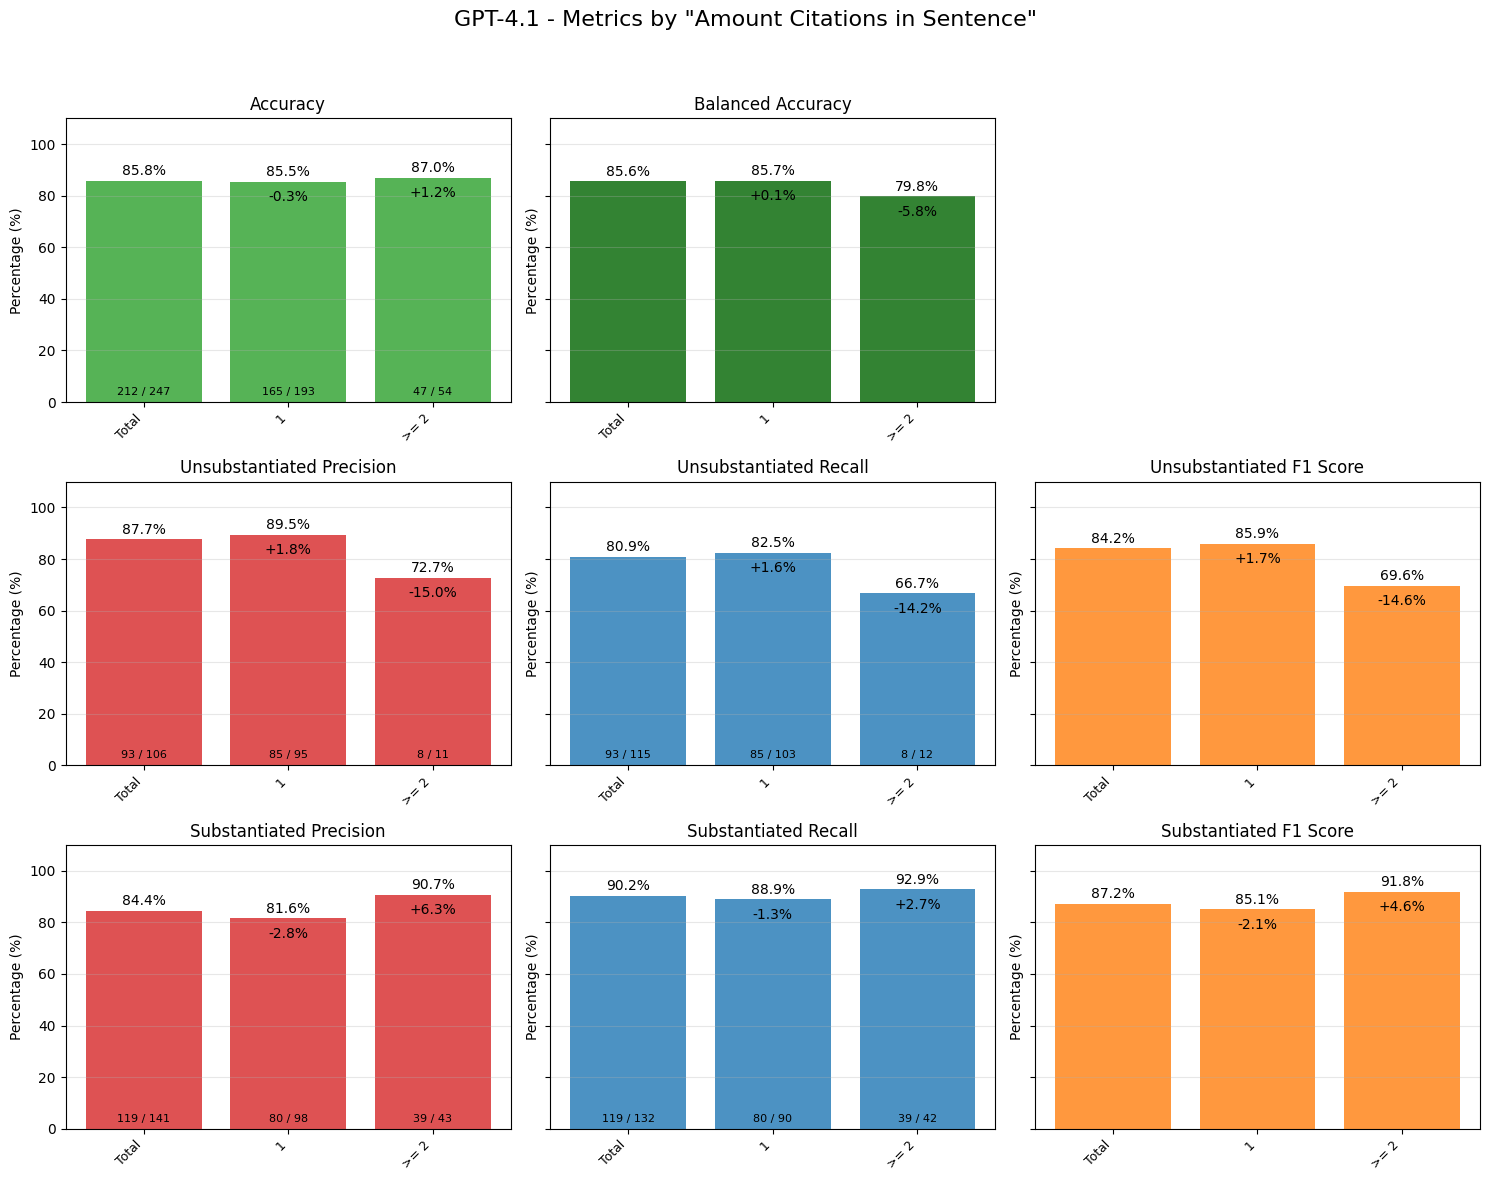

In [17]:
attribute = "Amount Citations in Sentence"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=2)
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [18]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute, group_numbers_from=2)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount Citations in Sentence': ## ----
Fisher's exact test results (per attribute value when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
1,0.8777,1.0000,2.3611,0.2396,0.6154,0.5499
>= 2,1.1394,1.0000,0.4235,0.2396,1.6250,0.5499


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,0.5233,0.4694,0.0000,1.0000,0.0029,0.9574


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000600,0.6470,N/A,N/A,N/A,N/A
Accuracy,0.000000,0.3460,N/A,N/A,N/A,N/A
Precision,N/A,N/A,0.013500,0.0030,0.004800,0.0300
Recall,N/A,N/A,-0.001700,0.7620,-0.000900,0.8030
F1 Score,N/A,N/A,0.002500,0.0530,0.001400,0.0560


### Amount References for Claim

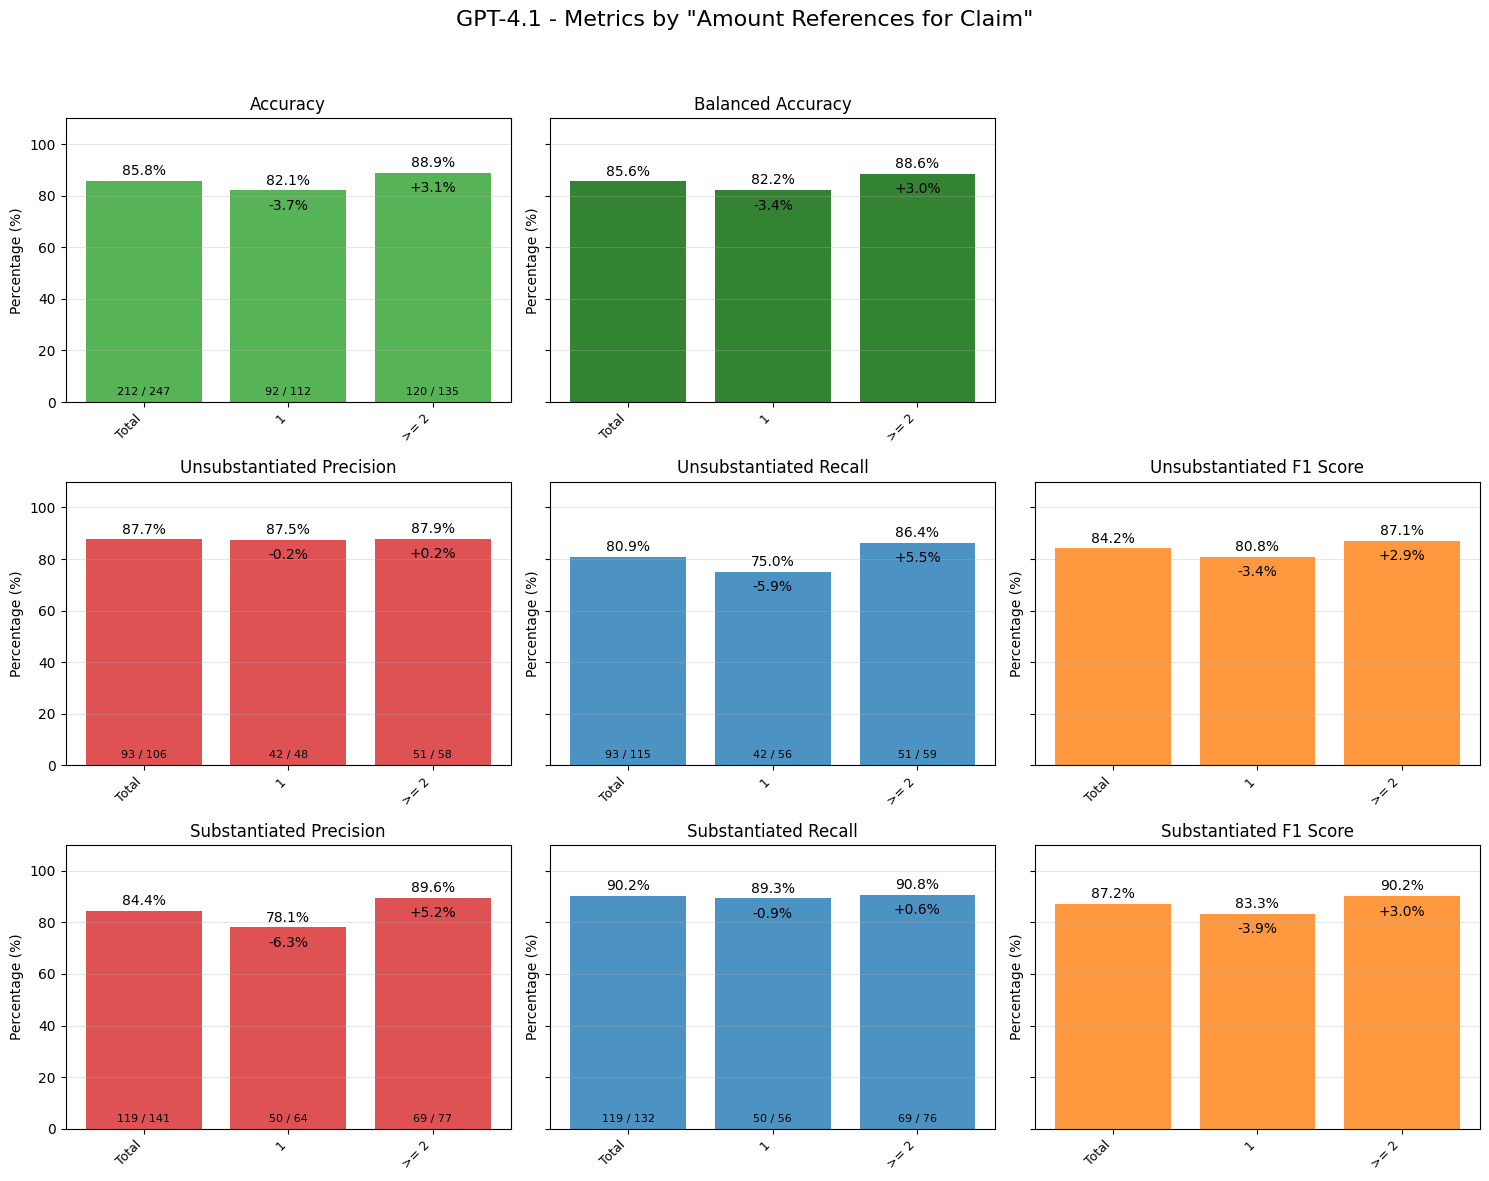

In [19]:
attribute = "Amount References for Claim"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=2)
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [20]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute, group_numbers_from=2)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount References for Claim': ## ----
Fisher's exact test results (per attribute value when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
1,0.5750,0.1453,0.4706,0.1558,0.8454,0.7764
>= 2,1.7391,0.1453,2.1250,0.1558,1.1829,0.7764


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,0.4508,0.5019,0.9876,0.3203,0.0006,0.9797


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.000200,0.4310,N/A,N/A,N/A,N/A
Accuracy,-0.000100,0.3990,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.000700,0.6420,0.001200,0.1560
Recall,N/A,N/A,0.000600,0.2340,-0.000600,0.7450
F1 Score,N/A,N/A,-0.000400,0.5660,-0.000100,0.3680


### Claim Sentence Structure

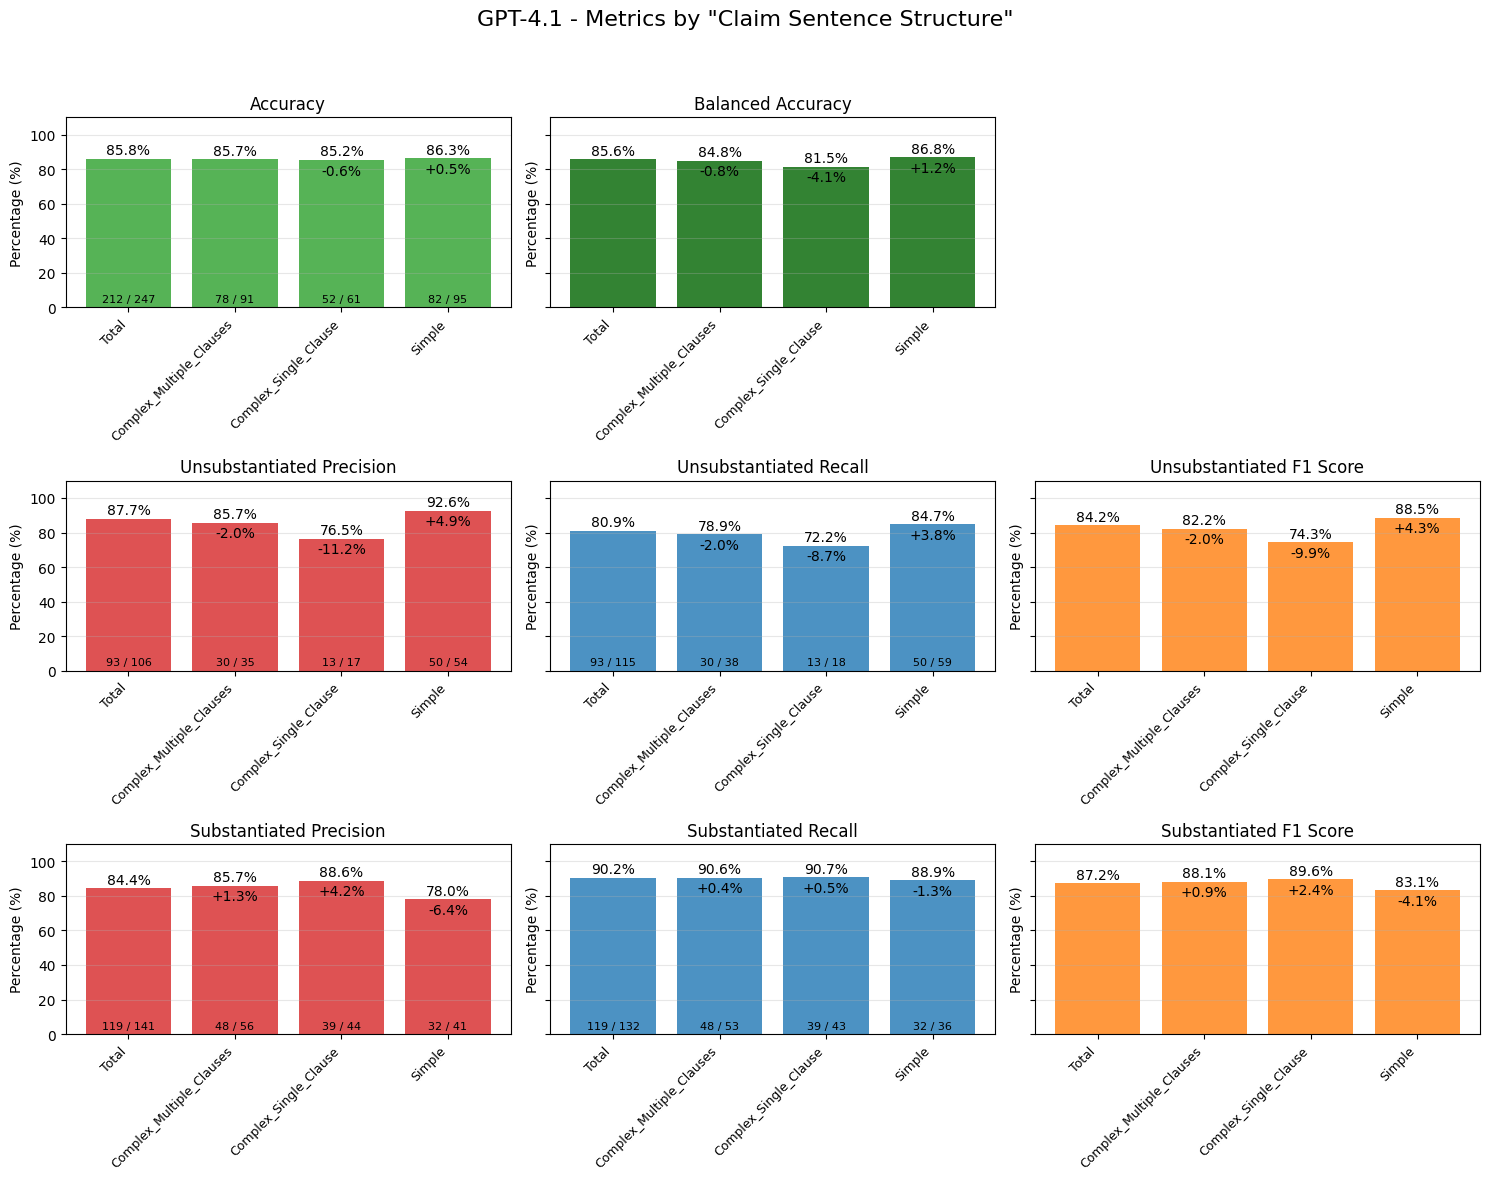

In [21]:
attribute = "Claim Sentence Structure"
results = attribute_predictions_per_model(model_dfs, attribute)
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [22]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute)

---- ## Significance tests results for GPT-4.1 on attribute 'Claim Sentence Structure': ## ----
Fisher's exact test results (per attribute value when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
Simple,1.0675,1.0000,1.6796,0.3453,0.8276,0.7500
Complex_Multiple_Clauses,0.9851,1.0000,0.8333,0.8021,1.0817,1.0000
Complex_Single_Clause,0.9389,0.8356,0.5525,0.3331,1.0969,1.0000


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,0.5858,0.7461,0.2808,0.8690,0.1593,0.9234


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,-0.001000,0.8800,N/A,N/A,N/A,N/A
Accuracy,-0.000700,0.6980,N/A,N/A,N/A,N/A
Precision,N/A,N/A,0.002800,0.0900,0.003600,0.0620
Recall,N/A,N/A,-0.002600,0.8870,-0.001300,0.9440
F1 Score,N/A,N/A,0.000000,0.3570,0.000900,0.1320


### Amount Claims to Substantiate

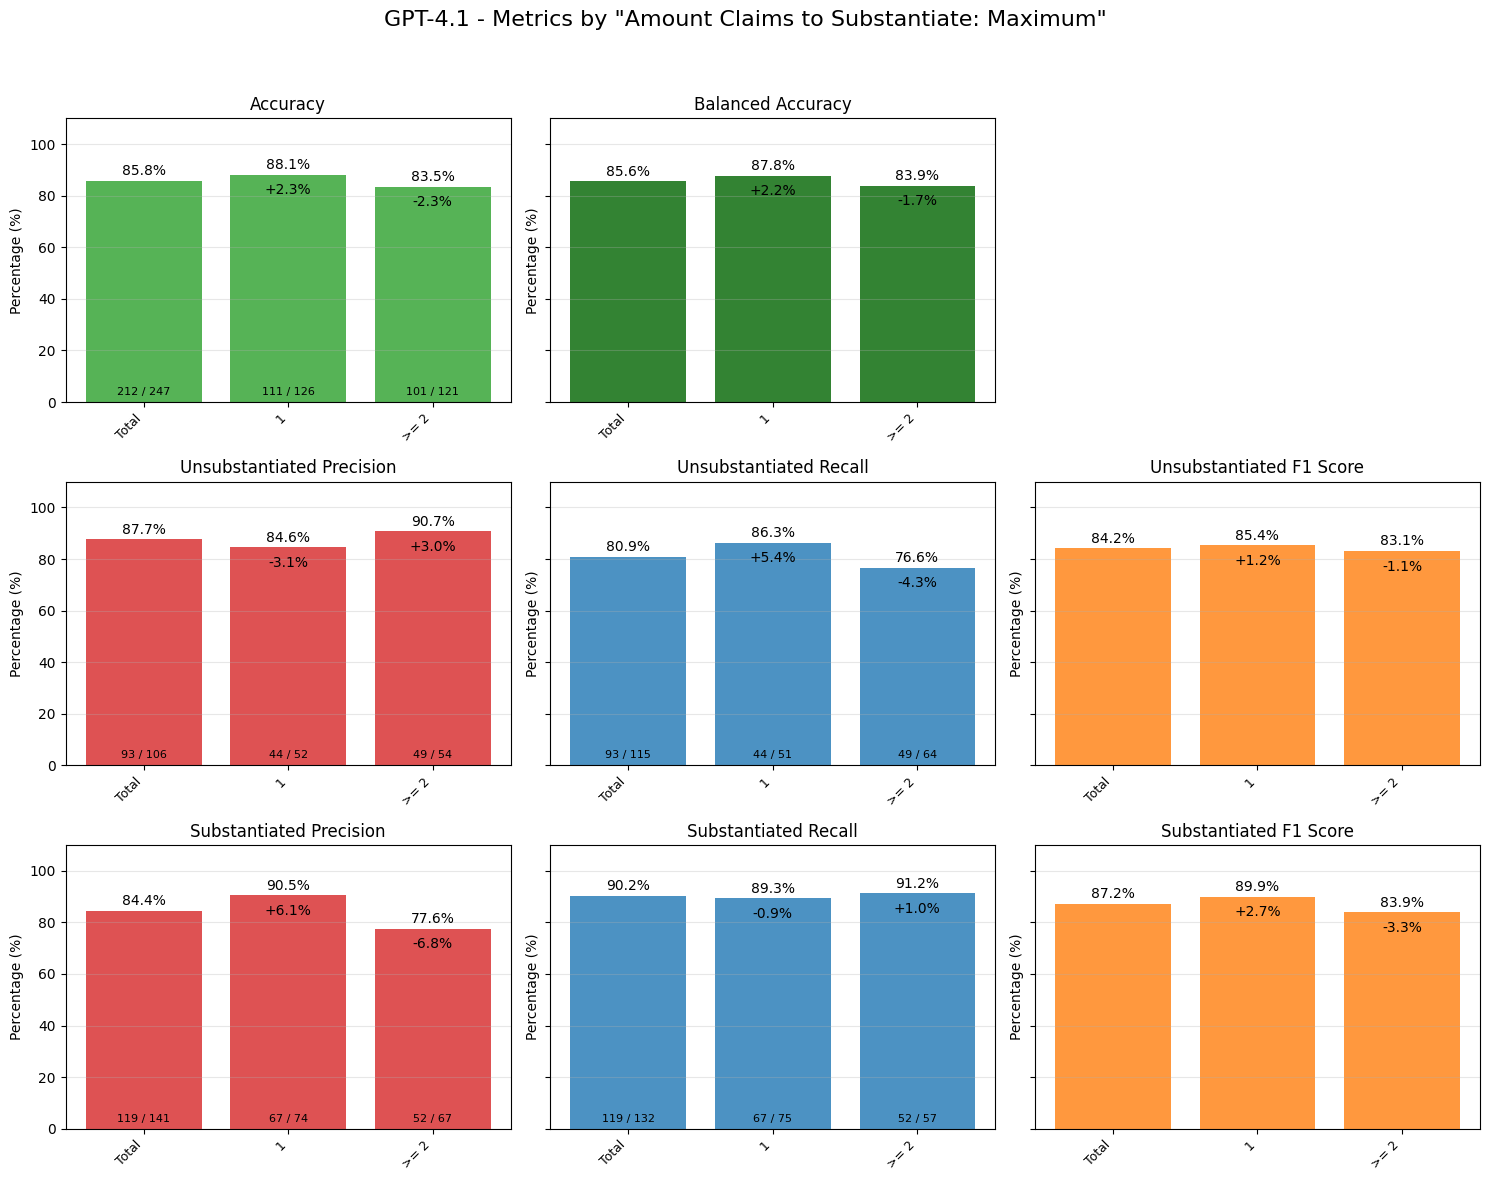

In [23]:
attribute = "Amount Claims to Substantiate: Maximum"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=2)
show_metrics_by_attribute_values(results, attribute, analyzed_model)

In [24]:
significance_tests_results[attribute] = significance_tests_for_attribute(analyzed_df, analyzed_model, attribute, group_numbers_from=2)

---- ## Significance tests results for GPT-4.1 on attribute 'Amount Claims to Substantiate: Maximum': ## ----
Fisher's exact test results (per attribute value when compared to rest):


,Total Odds Ratio,Total P-value,Unsubstantiated Odds Ratio,Unsubstantiated P-value,Substantiated Odds Ratio,Substantiated P-value
Attribute Value,,,,,,
1,1.4653,0.3623,1.9242,0.2361,0.8053,0.7764
>= 2,0.6824,0.3623,0.5197,0.2361,1.2418,0.7764


Chi-squared test results (comparison over all attribute values):


,Total Chi2,Total P-value,Unsubstantiated Chi2,Unsubstantiated P-value,Substantiated Chi2,Substantiated P-value
0,1.4773,0.2242,1.5705,0.2101,0.0000,1.0000


Permutation test results (comparison per metric over 1000 permutations):


,Total Var Diff,Total P-value,Unsubstantiated Var Diff,Unsubstantiated P-value,Substantiated Var Diff,Substantiated P-value
Metric,,,,,,
Balanced Accuracy,0.000300,0.2340,N/A,N/A,N/A,N/A
Accuracy,0.000400,0.1850,N/A,N/A,N/A,N/A
Precision,N/A,N/A,-0.000800,0.6620,0.003300,0.0380
Recall,N/A,N/A,0.001700,0.1520,-0.000600,0.9520
F1 Score,N/A,N/A,-0.000200,0.4040,0.000800,0.1050


## Overall Evaluation of Significance Test Results

In [25]:
significance_results = extract_p_values(significance_tests_results)

In [26]:
attributes = list(significance_results.keys())
attributes

['Reference Only',
 'Claim Contains Number or Formula',
 'Amount Citations in Sentence',
 'Amount References for Claim',
 'Claim Sentence Structure',
 'Amount Claims to Substantiate: Maximum']

In [27]:
p_values_by_test = reorganize_p_values_by_test_type(significance_results)

### Bonferroni Procedure for Fisher's Exact Test Results

In [28]:
fisher_exact_results = p_values_by_test['Fisher Exact']

for label_set in fisher_exact_results:
    print(f"---- Label set: {label_set} ----")
    results_with_adjusted_p_values = apply_fisher_bonferroni_p_value_correction(label_set, fisher_exact_results)
    display_fisher_bonferroni_results_table(results_with_adjusted_p_values)

---- Label set: Total ----


,Attribute Name,Attribute Value,Original p-value,Adjusted p-value,Significant
0,Reference Only,Yes,0.3129,1.0000,No
1,Reference Only,No,0.3129,1.0000,No
2,Claim Contains Number or Formula,No,0.1337,0.8022,No
3,Claim Contains Number or Formula,Number,0.1107,0.6642,No
4,Claim Contains Number or Formula,Formula,1.0000,1.0000,No
5,Amount Citations in Sentence,1,1.0000,1.0000,No
6,Amount Citations in Sentence,>= 2,1.0000,1.0000,No
7,Amount References for Claim,1,0.1453,0.8718,No
8,Amount References for Claim,>= 2,0.1453,0.8718,No
9,Claim Sentence Structure,Simple,1.0000,1.0000,No


---- Label set: Substantiated ----


,Attribute Name,Attribute Value,Original p-value,Adjusted p-value,Significant
0,Reference Only,Yes,0.2172,1.0000,No
1,Reference Only,No,0.2172,1.0000,No
2,Claim Contains Number or Formula,No,0.0421,0.2526,No
3,Claim Contains Number or Formula,Number,0.1105,0.6630,No
4,Claim Contains Number or Formula,Formula,0.1879,1.0000,No
5,Amount Citations in Sentence,1,0.5499,1.0000,No
6,Amount Citations in Sentence,>= 2,0.5499,1.0000,No
7,Amount References for Claim,1,0.7764,1.0000,No
8,Amount References for Claim,>= 2,0.7764,1.0000,No
9,Claim Sentence Structure,Simple,0.7500,1.0000,No


---- Label set: Unsubstantiated ----


,Attribute Name,Attribute Value,Original p-value,Adjusted p-value,Significant
0,Reference Only,Yes,0.7769,1.0000,No
1,Reference Only,No,0.7769,1.0000,No
2,Claim Contains Number or Formula,No,0.7467,1.0000,No
3,Claim Contains Number or Formula,Number,0.4659,1.0000,No
4,Claim Contains Number or Formula,Formula,1.0000,1.0000,No
5,Amount Citations in Sentence,1,0.2396,1.0000,No
6,Amount Citations in Sentence,>= 2,0.2396,1.0000,No
7,Amount References for Claim,1,0.1558,0.9348,No
8,Amount References for Claim,>= 2,0.1558,0.9348,No
9,Claim Sentence Structure,Simple,0.3453,1.0000,No


### Holm Procedure for Chi-Squared and Permutation Test Results

#### Chi-Squared Test Results

In [29]:
chi_squared_results = p_values_by_test['Chi-Squared']
chi_squared_results

for label_set in chi_squared_results:
    rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(chi_squared_results[label_set])
    print(f"---- Label set: {label_set} ----")
    print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Chi-Squared'], label_set)

---- Label set: Total ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.2242,1.0000,No
1,Reference Only,0.2517,1.0000,No
2,Amount Citations in Sentence,0.4694,1.0000,No
3,Amount References for Claim,0.5019,1.0000,No
4,Claim Contains Number or Formula,0.6586,1.0000,No
5,Claim Sentence Structure,0.7461,0.7461,No


---- Label set: Substantiated ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Claim Contains Number or Formula,0.0429,0.2574,No
1,Reference Only,0.4039,1.0000,No
2,Claim Sentence Structure,0.9234,1.0000,No
3,Amount Citations in Sentence,0.9574,1.0000,No
4,Amount References for Claim,0.9797,1.0000,No
5,Amount Claims to Substantiate: Maximum,1.0000,1.0000,No


---- Label set: Unsubstantiated ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.2101,1.0000,No
1,Amount References for Claim,0.3203,1.0000,No
2,Claim Contains Number or Formula,0.6555,1.0000,No
3,Claim Sentence Structure,0.8690,1.0000,No
4,Reference Only,0.8978,1.0000,No
5,Amount Citations in Sentence,1.0000,1.0000,No


#### Permutation Test Results

In [30]:
chi_squared_results = p_values_by_test['Chi-Squared']

for label_set in chi_squared_results:
    rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(chi_squared_results[label_set])
    print(f"---- Label set: {label_set} ----")
    print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Chi-Squared'], label_set)

---- Label set: Total ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.2242,1.0000,No
1,Reference Only,0.2517,1.0000,No
2,Amount Citations in Sentence,0.4694,1.0000,No
3,Amount References for Claim,0.5019,1.0000,No
4,Claim Contains Number or Formula,0.6586,1.0000,No
5,Claim Sentence Structure,0.7461,0.7461,No


---- Label set: Substantiated ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Claim Contains Number or Formula,0.0429,0.2574,No
1,Reference Only,0.4039,1.0000,No
2,Claim Sentence Structure,0.9234,1.0000,No
3,Amount Citations in Sentence,0.9574,1.0000,No
4,Amount References for Claim,0.9797,1.0000,No
5,Amount Claims to Substantiate: Maximum,1.0000,1.0000,No


---- Label set: Unsubstantiated ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.2101,1.0000,No
1,Amount References for Claim,0.3203,1.0000,No
2,Claim Contains Number or Formula,0.6555,1.0000,No
3,Claim Sentence Structure,0.8690,1.0000,No
4,Reference Only,0.8978,1.0000,No
5,Amount Citations in Sentence,1.0000,1.0000,No


In [31]:
permutation_results = p_values_by_test['Permutation Test']

for label_set in permutation_results:
    for metric in permutation_results[label_set]:
        rejected_null_hypotheses, accepted_null_hypotheses = holm_p_value_correction(permutation_results[label_set][metric])
        print(f"---- Label set: {label_set}, Metric: {metric} ----")
        print_holm_correction_results_as_table(rejected_null_hypotheses, accepted_null_hypotheses, p_values_by_test['Permutation Test'][label_set], metric)

---- Label set: Total, Metric: Accuracy ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Reference Only,0.1760,1.0000,No
1,Amount Claims to Substantiate: Maximum,0.1850,0.9250,No
2,Amount Citations in Sentence,0.3460,1.0000,No
3,Amount References for Claim,0.3990,1.0000,No
4,Claim Sentence Structure,0.6980,1.0000,No
5,Claim Contains Number or Formula,0.8810,0.8810,No


---- Label set: Total, Metric: Balanced Accuracy ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.2340,1.0000,No
1,Reference Only,0.3040,1.0000,No
2,Amount References for Claim,0.4310,1.0000,No
3,Amount Citations in Sentence,0.6470,1.0000,No
4,Claim Contains Number or Formula,0.7290,1.0000,No
5,Claim Sentence Structure,0.8800,0.8800,No


---- Label set: Substantiated, Metric: Precision ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0300,0.1800,No
1,Amount Claims to Substantiate: Maximum,0.0380,0.1900,No
2,Claim Sentence Structure,0.0620,0.2480,No
3,Reference Only,0.1370,0.4110,No
4,Amount References for Claim,0.1560,0.3120,No
5,Claim Contains Number or Formula,0.7950,0.7950,No


---- Label set: Substantiated, Metric: Recall ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Claim Contains Number or Formula,0.0580,0.3480,No
1,Reference Only,0.2720,1.0000,No
2,Amount References for Claim,0.7450,1.0000,No
3,Amount Citations in Sentence,0.8030,1.0000,No
4,Claim Sentence Structure,0.9440,1.0000,No
5,Amount Claims to Substantiate: Maximum,0.9520,0.9520,No


---- Label set: Substantiated, Metric: F1 Score ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0560,0.3360,No
1,Reference Only,0.0790,0.3950,No
2,Amount Claims to Substantiate: Maximum,0.1050,0.4200,No
3,Claim Sentence Structure,0.1320,0.3960,No
4,Claim Contains Number or Formula,0.1360,0.2720,No
5,Amount References for Claim,0.3680,0.3680,No


---- Label set: Unsubstantiated, Metric: Precision ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0030,0.0180,Yes
1,Claim Sentence Structure,0.0900,0.4500,No
2,Claim Contains Number or Formula,0.4140,1.0000,No
3,Amount References for Claim,0.6420,1.0000,No
4,Amount Claims to Substantiate: Maximum,0.6620,1.0000,No
5,Reference Only,0.7990,0.7990,No


---- Label set: Unsubstantiated, Metric: Recall ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Claims to Substantiate: Maximum,0.1520,0.9120,No
1,Amount References for Claim,0.2340,1.0000,No
2,Claim Contains Number or Formula,0.5610,1.0000,No
3,Reference Only,0.6430,1.0000,No
4,Amount Citations in Sentence,0.7620,1.0000,No
5,Claim Sentence Structure,0.8870,0.8870,No


---- Label set: Unsubstantiated, Metric: F1 Score ----


,Test Name,Original p-value,Adjusted p-value,Significant
0,Amount Citations in Sentence,0.0530,0.3180,No
1,Claim Sentence Structure,0.3570,1.0000,No
2,Amount Claims to Substantiate: Maximum,0.4040,1.0000,No
3,Amount References for Claim,0.5660,1.0000,No
4,Reference Only,0.6100,1.0000,No
5,Claim Contains Number or Formula,0.7920,0.7920,No
